In [1]:
%matplotlib inline
import obspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates


from hydrophone_data_processing import load, preprocessing, tempmatch
# from multitaper.multitaper import Multitaper
# from spectrum import *
import spectrum

In [2]:
temp = tempmatch.make_template(hole='B')

In [3]:
detectfiles = '/media/sda/data/borehole/detections/*.csv'
bubbles = load.import_detections(detectfiles)

In [4]:
paths = ['/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.02.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.03.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.04.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.05.GDH.2019.138'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.06.GDH.2019.138']

day138 = load.import_corrected_data_for_single_day(paths=paths)

In [5]:
day138

6 Trace(s) in Stream:
7F.B00.01.GDH | 2019-05-18T00:00:02.907000Z - 2019-05-19T00:00:01.019000Z | 1000.0 Hz, 86398113 samples
7F.B00.02.GDH | 2019-05-18T00:00:01.540000Z - 2019-05-19T00:00:00.847000Z | 1000.0 Hz, 86399308 samples
7F.B00.03.GDH | 2019-05-18T00:00:02.689000Z - 2019-05-19T00:00:03.138000Z | 1000.0 Hz, 86400450 samples
7F.B00.04.GDH | 2019-05-18T00:00:02.341000Z - 2019-05-19T00:00:01.086000Z | 1000.0 Hz, 86398746 samples
7F.B00.05.GDH | 2019-05-18T00:00:02.971000Z - 2019-05-19T00:00:01.291000Z | 1000.0 Hz, 86398321 samples
7F.B00.06.GDH | 2019-05-18T00:00:02.192000Z - 2019-05-19T00:00:01.375000Z | 1000.0 Hz, 86399184 samples

/home/john/anaconda3/envs/borehole/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


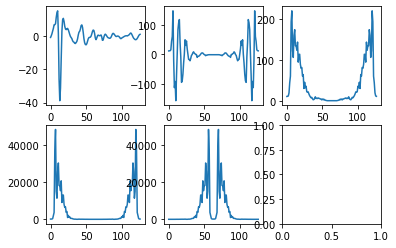

In [6]:
fig, ax = plt.subplots(2, 3)
ax[0][0].plot(temp[0].data)
y = np.fft.fft(temp[0].data)
ax[0][1].plot(y)
y = np.absolute(y)
ax[0][2].plot(y)
y = y**2
ax[1][0].plot(y)
y = np.fft.fftshift(y)
ax[1][1].plot(y)

In [7]:
128/4

32.0

In [8]:
def zero_pad(data, N, k):
    data_length = N*k
    extra_zeros = np.zeros(int(data_length - data.shape[0]))
    data = np.append(data, extra_zeros)
    return data

x = np.ones(10)
zero_pad(x, N=32, k=4)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [45]:
N = 64
# NW = 2.5
NW = 3/2
k = 4
w, eigens = spectrum.dpss(N, NW, k)
data = zero_pad(temp[0].data.copy(), N, k)
# data = np.reshape(data, (4, 32))
data = np.reshape(data, (k, N))
sk, weights, eigenvalues = spectrum.pmtm(data, e=eigens, v=w, method='eigen')

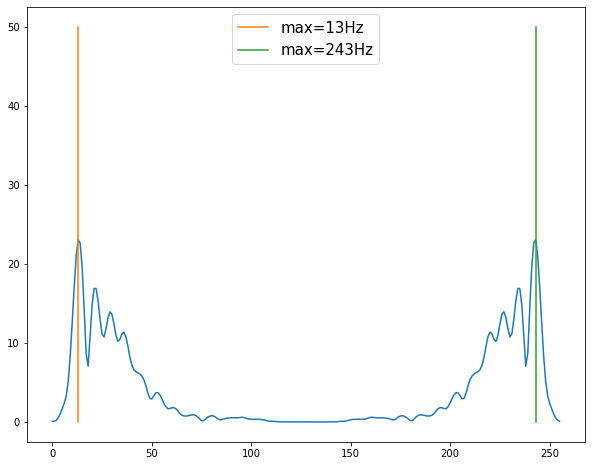

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))
sk0 = np.abs(sk[0])
ax.plot(sk0)
ax.plot([np.argmax(sk0), np.argmax(sk0)]
         , [0, 50]
         , label='max={}Hz'.format(np.argmax(sk0))
         )
ax.plot([np.argmax(sk0[50:])+50, np.argmax(sk0[50:])+50]
         , [0, 50]
         , label='max={}Hz'.format(np.argmax(sk0[50:])+50)
         )
ax.legend(fontsize=15)

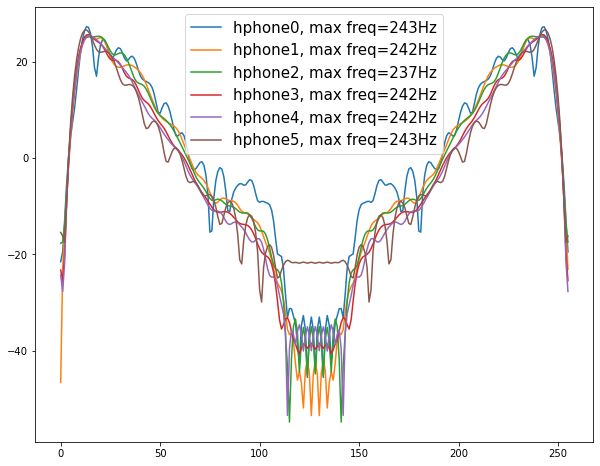

In [107]:
fig, ax = plt.subplots(figsize=(10, 8))

for n,t in enumerate(temp):
    N = 64
    # NW = 2.5
    NW = 3/2
    k = 4
    w, eigens = spectrum.dpss(N, NW, k)
    # data = zero_pad(temp[0].data.copy(), N, k)
    data = zero_pad(t.data.copy(), N, k)
    # data = np.reshape(data, (4, 32))
    data = np.reshape(data, (k, N))
    sk, weights, eigenvalues = spectrum.pmtm(data, e=eigens, v=w, method='eigen')
    
    # sk0 = np.abs(sk[0])
    sk0 = np.abs(sk[0]*weights[0])
    sk0 = 10*np.log10(sk0**2)
    # sk0 = 10*np.log10(sk0)
    ax.plot(sk0, label='hphone{n}, max freq={f}Hz'.format(n=n, f=np.argmax(sk0[50:])+50))
    # ax.plot([np.argmax(sk0), np.argmax(sk0)]
    #          , [0, 50]
    #          , label='max={}Hz'.format(np.argmax(sk0))
    #          )
    # ax.plot([np.argmax(sk0[50:])+50, np.argmax(sk0[50:])+50]
    #          , [0, 50]
    #          , label='max={}Hz'.format(np.argmax(sk0[50:])+50)
    #          )
ax.legend(fontsize=15)
# ax.set_xlim(125, 260)
# ax.set_ylim(-5, 30)
# ax.set_yscale('log')

In [104]:
weights[0]

array([ 0.99889949])

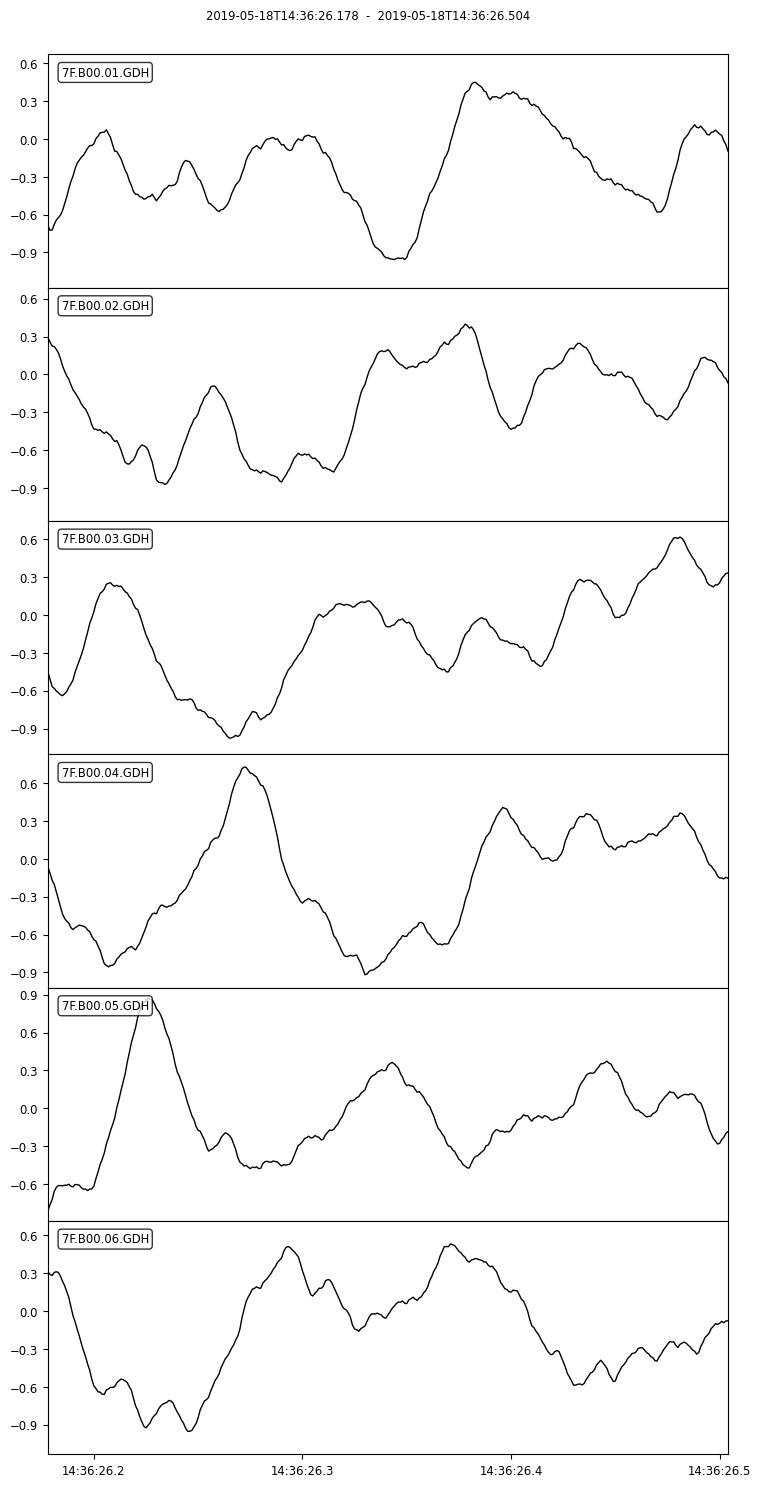

(200.0, 260.0)

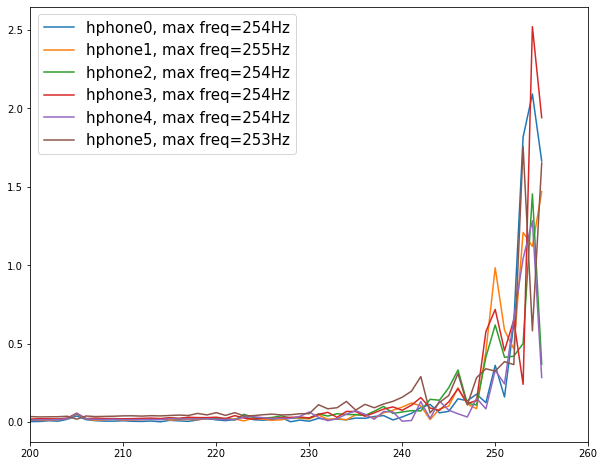

In [93]:
data = day138.slice(starttime=temp[0].stats.starttime+10, endtime=temp[0].stats.endtime+10.2).copy()
x = data.plot()
fig, ax = plt.subplots(figsize=(10, 8))

for n,t in enumerate(data):
    N = 512
    # NW = 2.5
    NW = 3/2
    k = 4
    w, eigens = spectrum.dpss(N, NW, k)
    # data = zero_pad(temp[0].data.copy(), N, k)
    data = zero_pad(t.data.copy(), N, k)
    # data = np.reshape(data, (4, 32))
    data = np.reshape(data, (k, N))
    sk, weights, eigenvalues = spectrum.pmtm(data, e=eigens, v=w, method='eigen')
    
    sk0 = np.abs(sk[0])
    ax.plot(sk0, label='hphone{n}, max freq={f}Hz'.format(n=n, f=np.argmax(sk0[50:])+50))
    # ax.plot([np.argmax(sk0), np.argmax(sk0)]
    #          , [0, 50]
    #          , label='max={}Hz'.format(np.argmax(sk0))
    #          )
    # ax.plot([np.argmax(sk0[50:])+50, np.argmax(sk0[50:])+50]
    #          , [0, 50]
    #          , label='max={}Hz'.format(np.argmax(sk0[50:])+50)
    #          )
ax.legend(fontsize=15)
ax.set_xlim(200, 260)
# ax.set_ylim(-5, 30)

In [13]:
def minnaert_radius(freq):
    # gamma = np.mean([1.3, 1.67]) # dimensionless
    # https://www.engineeringtoolbox.com/specific-heat-capacity-gases-d_159.html
    gamma = 1.405 # taken from website above for 300K
    # PA = 2.5 # bar, 100 kPa, N/m^2, kg*m/s^2m^2 = 100000 kg*m/(s^2 m^2) = 100000 kg/(m*s^2)
    # rho = 1 # density of water, 997 kg/m^3
    PA = 2.5 * 100000 # kg/(m*s^2)
    rho = 997 # kg/m^3
    # PA/rho => PA(kg*m^-1*s^-2) / rho(kg * m^-3) =? PA(...) * rho(kg^-1 * m^3) => m^2 * s^-2
    return (2 * np.pi * freq)**(-1) * ((3 * gamma * PA)/(rho))**(1/2)

In [14]:
minnaert_radius(freq=21) # units - meters

0.24638941792829613

In [15]:
minnaert_radius(freq=235) # units - meters

0.022017777772315825

In [16]:
np.mean([1.3, 1.67])

1.4849999999999999

In [17]:
np.savetxt(X=temp[0].data, delimiter=',', fname='bubbletemplate.csv')

In [18]:
# data.shape

In [19]:
# data_length


In [20]:
# for n in np.arange(0, 10, 2):
#     print(n*n)

In [21]:
# mtp = Multitaper(16)

In [22]:
# data = temp[0].data.copy()
# data = np.append(data, (0,))
# np.reshape(data, (6, 16))

In [23]:
# plt.plot(mtp.estimate(np.reshape(data, (-1, 16))))

In [24]:
# 126/6

In [25]:
# mtp.estimate(data)

In [26]:
# np.reshape(temp[0].data, (3, 3))

In [27]:
# 127/7

In [28]:
# np.reshape(temp[0].data, (7, -1))

In [29]:
# mymtm = Multitaper(2048)
# sig = np.vectorize(complex)(np.random.rand(2048), np.random.rand(2048))
# plt.plot(mymtm.estimate(sig))
# plt.yscale('log')

In [30]:
# sig

In [31]:
# mymtm = Multitaper(256)
# sig = np.reshape(sig, (8, 256))
# print(mymtm.estimate(sig))